In [107]:
#HYPERPARAMETERS - FEEL FREE TO TWEAK

DEBUG_STATEMENTS = False # feel free to change this to True and TRIALS to 1 to run a single simulation.
#DEBUG_STATEMENTS = True

TRIALS = 1000000 # number of trials to run. the higher the number, the more accurate the simulation, but runs for longer.
#TRIALS = 1

PITY_THRESHOLD = 4 #how many off from guarantee pity to trigger rolling singles at pity trick.

#--------------------------------------------
# The following setting is not applicable to checking for average gem spent.

NUM_OF_STEPS = 9  # 12k gems spent is five steps, for each over step you spend 3k more.
# 9 steps is finishing box1 only. 10 steps is 27k gems, the same amount as 11-step on an arcana banner.
# 17 steps is 48k gems spent, a.k.a. the point at which spark is guaranteed.

#--------------------------------------------
# The following settings are regarding spotlight banners.

SET_1_NON_EXCELLENT_WEIGHT = 6
# ^probability to get any non-excellent prize is the probability to get any excellent prize multiplied by the weight

FIRST_THREE_STEPS_NON_EXCELLENT_WEIGHT = 15 # Data evidence suggests steps 1-3 have even lower rates for excellents

SET_1_EXCELLENT_NOT_GIRL_WEIGHT = 2
# ^probability of any non-stage-girl excellent prize is the probability to get the stage-girl prize multiplied by the weight
# if this number is 2, then each excellent prize will have equal chance to appear on the very first excellent prize roll.

SET_2_NON_EXCELLENT_WEIGHT = 6
# ^probability to get any non-excellent prize is the probability to get any excellent prize multiplied by the weight

SET_2_EXCELLENT_NOT_GIRL_WEIGHT = 3
# ^probability of any non-stage-girl excellent prize is the probability to get any stage-girl prize multiplied by the weight
# for example, if this number is 2, then - even though there are two slots for lovers,
# you still only have 33.3% chance to get Lover on the very first excellent prize roll.


In [79]:
# IMPORTS, GRAPHING, AND MISC SETUP
import random
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt

cost_buckets = list()
bday_histo = list()
arcana_histo = list()
spotlight_histo = list()
collab_histo = list()

for i in range(80):
    cost_buckets.append(i*1500)

PITY_COUNT = 0
SINGLES_USED = 0;

def reset_trial():
    global CURRENT_STEP; global PITY_COUNT;
    CURRENT_STEP = 1
    PITY_COUNT = 0
    
def updatePityCount(rate, times):
    global PITY_COUNT
    for i in range(times):
        if random.random() <= rate:
            if DEBUG_STATEMENTS:
                print(f"Pity broken on the {i+1}-roll of {times} total rolls")
            PITY_COUNT = 0
        else:
            PITY_COUNT += 1
    if DEBUG_STATEMENTS:
        print(f"new pity count: {PITY_COUNT}")

In [80]:
def getGemsSpent_OLD_FUNCTION (num_of_steps, mode):
    gems_spent = 0
    if mode == "SPOTLIGHT":
        for i in range(num_of_steps): #indices start at 0
            if i == 0:
                gems_spent += 1500
            elif i == 1:
                gems_spent += 2000
            elif i == 2:
                gems_spent += 2500
            else:
                gems_spent += 3000
    elif mode == "BDAY":
        for i in range(num_of_steps): #indices start at 0
            if i == 0 or i == 7:
                gems_spent += 1500
            elif i == 2:
                gems_spent += 0
            else:
                gems_spent += 3000
    elif mode == "COLLAB":
        for i in range(num_of_steps): #indices start at 0
            if i == 0:
                gems_spent += 900
            elif i == 1 or i == 4 or i == 8 or i == 11:
                gems_spent += 1500
            elif i == 2:
                gems_spent += 2000
            elif i == 7:
                gems_spent += 0
            else:
                gems_spent += 3000
    else: #ARCANA SUPERFEST
        for i in range(num_of_steps): #indices start at 0
            if i == 6 or i == 9:
                gems_spent += 1500
            elif i == 4:
                gems_spent += 0
            else:
                gems_spent += 3000
    return gems_spent

STEP_TYPES = {
    'BDAY': {
        0: 1500,
        7: 1500,
        2: 0,
    },
    'SPOTLIGHT': {
        0: 1500,
        1: 2000,
        2: 2500,
    },
    'COLLAB': {
        0: 900,
        1: 1500,
        2: 2000,
        4: 1500,
        7: 0,
        8: 1500,
        11: 1500,
    },
    'default': {
        6: 1500,
        9: 1500,
        4: 0,
    },
}

@lru_cache(None)
def getGemsSpent(num_steps, gacha_type):
    step_costs = STEP_TYPES.get(gacha_type, STEP_TYPES['default'])
    if num_steps > max(step_costs):
        steps = step_costs.values()
    else:
        steps = [cost for i, cost in step_costs.items()
                 if i < num_steps]
    return 3000 * (num_steps - len(steps)) + sum(steps)

In [81]:
#SPOTLIGHT GACHA DEFINITIONS

CURRENT_SET = 1; CURRENT_STEP = 1; SET1 = list(); SET2 = list()

def reset_spotlight_trial():
    global CURRENT_SET; global CURRENT_STEP; global SET1; global SET2
    CURRENT_SET = 1
    CURRENT_STEP = 1
    SET1 = list(["stage girl", "excellent", "excellent", "garbage","garbage","garbage","garbage","garbage","garbage"])
    SET2 = list(["lover", "lover", "excellent", "garbage","garbage","garbage","garbage","garbage","garbage"])
    
def acquire_Excellent_Prize (pool):
    if CURRENT_SET == 1:
        if ("excellent" not in pool):
            return pool.pop(pool.index("stage girl"))
        roll_range = 1 + SET_1_EXCELLENT_NOT_GIRL_WEIGHT
        if ("stage girl" in pool and random.random() * roll_range < 1):
            return pool.pop(pool.index("stage girl"))
    else: # CURRENT_SET == 2
        if ("excellent" not in pool):
            return pool.pop(pool.index("lover"))
        roll_range = 1 + SET_2_EXCELLENT_NOT_GIRL_WEIGHT
        if (random.random() * roll_range < 1):
            return pool.pop(pool.index("lover"))
    return pool.pop(pool.index("excellent"))

def simulateOneSpotlight(): # Simulate a single step. returns True if it succeeds in getting Lovers.
    global CURRENT_SET; global CURRENT_STEP; global SET1; global SET2
    
    if DEBUG_STATEMENTS:
        print(f"step: {CURRENT_STEP}, ", end="")
    
    # first, roll the 0.2% rate gacha "normally". chance of getting 1 or more copies of lovers in one 10x pull is 1.9821%
    if random.random() < 0.019821:
        if DEBUG_STATEMENTS:
            print ("Obtained in 0.2% gacha normally")
        return True
    
    # next, roll for a spotlight prize.
    roll_range = 0
    if (CURRENT_SET == 1):
        if (CURRENT_STEP != 4):
            if (CURRENT_STEP <= 3): # steps 1-3
                roll_range = 1 + FIRST_THREE_STEPS_NON_EXCELLENT_WEIGHT
            else: #steps 5-9
                roll_range = 1 + SET_1_NON_EXCELLENT_WEIGHT
            if ("garbage" not in SET1 or random.random() * roll_range < 1):
                if acquire_Excellent_Prize(SET1) == "stage girl":
                    if (random.random() < 0.4):
                        if (DEBUG_STATEMENTS):
                            print("Obtained in box1 stage girl excellent prize")
                        return True
                    if DEBUG_STATEMENTS:
                        print("Received: OLD stage girl")
                else:
                    if DEBUG_STATEMENTS:
                        print("Received: ordinary excellent prize")
            else: # failed to get an excellent prize
                SET1.pop(SET1.index("garbage"))
                if DEBUG_STATEMENTS:
                    print("Received: garbage")
        else: # CURRENT_STEP == 4
            if acquire_Excellent_Prize(SET1) == "stage girl":
                if (random.random() < 0.4):
                    if (DEBUG_STATEMENTS):
                        print("Obtained in box1 stage girl excellent prize")
                    return True
                if DEBUG_STATEMENTS:
                    print("Received: OLD stage girl")
            else:
                if DEBUG_STATEMENTS:
                    print("Received: ordinary excellent prize")
        # check if all three excellent prizes have been acquired in SET1
        if "stage girl" not in SET1 and "excellent" not in SET1:
            if (DEBUG_STATEMENTS):
                print ("changing set to BOX 2")
            CURRENT_SET = 2

    else: # CURRENT_SET == 2
        roll_range = 1 + SET_2_NON_EXCELLENT_WEIGHT
        if ("garbage" not in SET2 or random.random() * roll_range < 1):
            if acquire_Excellent_Prize(SET2) == "lover":
                if (DEBUG_STATEMENTS):
                    print("Obtained in box2 stage girl excellent prize")
                return True
            if DEBUG_STATEMENTS:
                print("Received: ordinary excellent prize")
        else: # failed to get an excellent prize
            SET2.pop(SET2.index("garbage"))
            if DEBUG_STATEMENTS:
                print("Received: garbage")
    
    CURRENT_STEP += 1
    
    if DEBUG_STATEMENTS:
        print("WHAT'S LEFT IN BOX: ", end="")
        print(SET1) if CURRENT_SET == 1 else print(SET2)
        print()
    
    return False

In [82]:
#10-STEP BIRTHDAY GACHA DEFINITIONS

def simulateOneBday(): # Simulate a single step. returns True if it succeeds in getting.
    global CURRENT_STEP; global PITY_COUNT; global PITY_THRESHOLD; global SINGLES_USED;
    if DEBUG_STATEMENTS:
        print(f"Starting step {CURRENT_STEP}")
    if CURRENT_STEP == 5: #memoir takes up one slot
        if random.random() < 0.061264511581829:
            if DEBUG_STATEMENTS:
                print("got in step 5")
            return True
    elif CURRENT_STEP == 6: #1.5 rate
        if random.random() < 0.1001751443194321779:
            if DEBUG_STATEMENTS:
                print("got in step 6")
            return True
    elif CURRENT_STEP == 7 or CURRENT_STEP > 10: #double rate
        if DEBUG_STATEMENTS:
            print("Note: applying double-rate for bday girl")
        if PITY_COUNT >= 90:
            PITY_COUNT = 0
            if random.random() < 0.6335:
                if DEBUG_STATEMENTS:
                    print(f"got in step {CURRENT_STEP} that includes PITY")
                return True
        elif PITY_COUNT >= (90 - PITY_THRESHOLD):
            for i in range(90 - PITY_COUNT):
                SINGLES_USED += 1
                if random.random() < 0.014: #currently step7 pity not implemented. this will have to be a switch if it is.
                    if DEBUG_STATEMENTS:
                        print(f"got in singles spook while attempting step {CURRENT_STEP} pity")
                    return True
                updatePityCount(0.024, 1)
                if PITY_COUNT < (90 - PITY_THRESHOLD):
                    if DEBUG_STATEMENTS:
                        print("Pity trick failed, resuming regular 10x pulls")
                    break
            if PITY_COUNT >= 90:
                PITY_COUNT = 0
                if random.random() < 0.6335:
                    if DEBUG_STATEMENTS:
                        print(f"got in PITY TRICK of step {CURRENT_STEP}")
                    return True
            else:
                if random.random() < 0.1315013466030288563:
                    if DEBUG_STATEMENTS:
                        print(f"got in step {CURRENT_STEP} (failed pity trick)")
                    return True
        else:
            if random.random() < 0.1315013466030288563:
                if DEBUG_STATEMENTS:
                    print(f"got in step {CURRENT_STEP}")
                return True
    elif CURRENT_STEP == 10:
        if PITY_COUNT >= (90 - PITY_THRESHOLD):
            for i in range(93 - PITY_COUNT):
                SINGLES_USED += 1
                if random.random() < 0.007:
                    if DEBUG_STATEMENTS:
                        print("got in singles spook while attempting step10 pity")
                    return True
                updatePityCount(0.024, 1)
                if (PITY_COUNT < 90):
                    if DEBUG_STATEMENTS:
                        print("Pity trick failed, resuming regular 10x pulls")
                    break
            if (PITY_COUNT >= 93):
                PITY_COUNT = 0
                if random.random() < 0.52344757331: #double-dip, the only case of two 4* guarantees
                    if DEBUG_STATEMENTS:
                        print("got in PITY TRICK of step 10")
                    return True
            else:
                PITY_COUNT = 0
                if random.random() < 0.33349780323:
                    if DEBUG_STATEMENTS:
                        print("got in step 10 (failed pity trick)")
                    return True
        else:
            PITY_COUNT = 0
            if random.random() < 0.33349780323:
                if DEBUG_STATEMENTS:
                    print("got in step 10")
                return True
    else: # step 1, 2, 3, 4, 8, or 9:
        if random.random() < 0.06783566:
            if DEBUG_STATEMENTS:
                print(f"got in step {CURRENT_STEP}")
            return True
    
    if CURRENT_STEP == 2:
        updatePityCount(0.036, 10)
    elif CURRENT_STEP == 4:
        updatePityCount(0.048, 10)
    elif CURRENT_STEP == 10:
        updatePityCount(0.024, 2)
    else:
        updatePityCount(0.024, 10)
    CURRENT_STEP += 1
    return False

In [83]:
#11-STEP TR SUPERFEST ARCANA GACHA DEFINITIONS
    
def simulateOneArcana(): # Simulate a single step. returns True if it succeeds in getting.
    global CURRENT_STEP; global PITY_COUNT; global PITY_THRESHOLD; global SINGLES_USED;
    if DEBUG_STATEMENTS:
        print(f"Starting step {CURRENT_STEP}")
    if CURRENT_STEP == 6: #1.5 rate
        if random.random() < 0.1001751443194321779:
            if DEBUG_STATEMENTS:
                print("got in step 6")
            return True
    elif CURRENT_STEP == 8: #double rate
        if DEBUG_STATEMENTS:
            print("Note: applying double-rate for featured girl")
        if PITY_COUNT >= 70:
            if DEBUG_STATEMENTS:
                print("Eligible for step 8 pity abuse. Applying 20 singles now.")
            for i in range(20):
                SINGLES_USED += 1
                if random.random() < 0.007:
                    if DEBUG_STATEMENTS:
                        print(f"got in singles spook while attempting step {CURRENT_STEP} pity")
                    return True
                updatePityCount(0.03, 1)
                if (PITY_COUNT < 70):
                    if DEBUG_STATEMENTS:
                        print("Pity trick failed, resuming regular 10x pulls")
                    break
            if PITY_COUNT >= 90:
                PITY_COUNT = 0
                if random.random() < 0.530782: #Note that this is for SUPER-type gacha (2.5x rates for 4* girls)
                    if DEBUG_STATEMENTS:
                        print(f"got in PITY TRICK of step {CURRENT_STEP}")
                    return True
            else:
                if random.random() < 0.1315013466030288563:
                    if DEBUG_STATEMENTS:
                        print(f"got in step {CURRENT_STEP} (failed pity trick)")
                    return True
        else:
            if random.random() < 0.1315013466030288563:
                if DEBUG_STATEMENTS:
                    print(f"got in step {CURRENT_STEP}")
                return True
    elif CURRENT_STEP == 11: #guaranteed any 4* girl
        if random.random() < 0.4171:
            if DEBUG_STATEMENTS:
                print("got in step 11")
            return True
    else: # step 1, 2, 3, 4, 5, 7, 9, 10, or 12+:
        if PITY_COUNT >= 90:
            PITY_COUNT = 0
            if random.random() < 0.4171:
                if DEBUG_STATEMENTS:
                    print(f"got in step {CURRENT_STEP} that includes PITY")
                return True
        elif PITY_COUNT >= (90 - PITY_THRESHOLD):
            for i in range(90 - PITY_COUNT):
                SINGLES_USED += 1
                if random.random() < 0.007:
                    if DEBUG_STATEMENTS:
                        print(f"got in singles spook while attempting step {CURRENT_STEP} pity")
                    return True
                updatePityCount(0.03, 1)
                if PITY_COUNT < (90 - PITY_THRESHOLD):
                    if DEBUG_STATEMENTS:
                        print("Pity trick failed, resuming regular 10x pulls")
                    break
            if PITY_COUNT >= 90:
                PITY_COUNT = 0
                if random.random() < 0.4171:
                    if DEBUG_STATEMENTS:
                        print(f"got in PITY TRICK of step {CURRENT_STEP}")
                    return True
            else:
                if random.random() < 0.06783566:
                    if DEBUG_STATEMENTS:
                        print(f"got in step {CURRENT_STEP} (failed pity trick)")
                    return True
        else:
            if random.random() < 0.06783566:
                if DEBUG_STATEMENTS:
                    print(f"got in step {CURRENT_STEP}")
                return True
    
    if CURRENT_STEP == 2:
        updatePityCount(0.036, 10)
    elif CURRENT_STEP == 3:
        updatePityCount(0.048, 10)
    elif CURRENT_STEP == 11:
        updatePityCount(0.03, 2)
    else:
        updatePityCount(0.03, 10)
    CURRENT_STEP += 1
    return False


In [84]:
#14-STEP COLLAB GACHA DEFINITIONS
    
def simulateOneCollab(): # Simulate a single step. returns True if it succeeds in getting.
    global CURRENT_STEP; global PITY_COUNT; global PITY_THRESHOLD; global SINGLES_USED;
    if DEBUG_STATEMENTS:
        print(f"Starting step {CURRENT_STEP}")
    if CURRENT_STEP == 7: #1.5 rate
        if random.random() < 0.1001751443194321779:
            if DEBUG_STATEMENTS:
                print("got in step 6")
            return True
    elif CURRENT_STEP == 11 or CURRENT_STEP == 14: #guaranteed any 4* girl
        if random.random() < 0.4171:
            if DEBUG_STATEMENTS:
                print(f"got in step {CURRENT_STEP}")
            return True
    elif CURRENT_STEP == 1: # 5 rolls
        if random.random() < 0.034513418:
            if DEBUG_STATEMENTS:
                print("got in step 1")
            return True
    elif CURRENT_STEP == 4 or CURRENT_STEP == 6: #memoir takes up one slot
        if random.random() < 0.061264511581829:
            if DEBUG_STATEMENTS:
                print(f"got in step {CURRENT_STEP}")
            return True
    else: # step 2, 3, 5, 8, 9, 10, 12, 13, 15+:
        if PITY_COUNT >= 90:
            PITY_COUNT = 0
            if random.random() < 0.4171:
                if DEBUG_STATEMENTS:
                    print(f"got in step {CURRENT_STEP} that includes PITY")
                return True
        elif PITY_COUNT >= (90 - PITY_THRESHOLD):
            for i in range(90 - PITY_COUNT):
                SINGLES_USED += 1
                if random.random() < 0.007:
                    if DEBUG_STATEMENTS:
                        print(f"got in singles spook while attempting step {CURRENT_STEP} pity")
                    return True
                updatePityCount(0.024, 1)
                if PITY_COUNT < (90 - PITY_THRESHOLD):
                    if DEBUG_STATEMENTS:
                        print("Pity trick failed, resuming regular 10x pulls")
                    break
            if PITY_COUNT >= 90:
                PITY_COUNT = 0
                if random.random() < 0.4171:
                    if DEBUG_STATEMENTS:
                        print(f"got in PITY TRICK of step {CURRENT_STEP}")
                    return True
            else:
                if random.random() < 0.06783566:
                    if DEBUG_STATEMENTS:
                        print(f"got in step {CURRENT_STEP} (failed pity trick)")
                    return True
        else:
            if random.random() < 0.06783566:
                if DEBUG_STATEMENTS:
                    print(f"got in step {CURRENT_STEP}")
                return True
    
    if CURRENT_STEP == 3:
        updatePityCount(0.036, 10)
    elif CURRENT_STEP == 11 or CURRENT_STEP == 14:
        updatePityCount(0.024, 2)
    else:
        updatePityCount(0.024, 10)
    CURRENT_STEP += 1
    return False

In [108]:
# RUN THIS CELL FOR DETERMINING AVERAGE GEM SPENT

cumulative_singles_used = 0
steps_used = 0

spotlight_cumulative_gem_spent = 0
bday_cumulative_gem_spent = 0
arcana_cumulative_gem_spent = 0
collab_cumulative_gem_spent = 0

"""
for i in range(TRIALS):
    reset_spotlight_trial()
    while True:
        steps_used += 1
        if simulateOneSpotlight() == True:
            spotlight_cumulative_gem_spent += getGemsSpent(steps_used, "SPOTLIGHT")
            steps_used = 0
            break

average_spotlight_spent = spotlight_cumulative_gem_spent / TRIALS

print()
print(f"AFTER RUNNING {TRIALS} TRIALS,")
print(f"Experimentally determined avg gem spent to get the girl on a spotlight banner is {average_spotlight_spent}")

for i in range(TRIALS):
    reset_trial()
    while True:
        steps_used += 1
        if simulateOneBday() == True:
            gemsForThisTrial = getGemsSpent(steps_used, "BDAY")
            gemsForThisTrial += SINGLES_USED * 300
            cumulative_singles_used += SINGLES_USED
            SINGLES_USED = 0
            bday_histo.append(gemsForThisTrial)
            bday_cumulative_gem_spent += gemsForThisTrial
            steps_used = 0
            break

print(f"single pulls used: {SINGLES_USED}")
bday_cumulative_gem_spent += SINGLES_USED * 300
average_bday_spent = bday_cumulative_gem_spent / TRIALS

for i in range(TRIALS):
    reset_trial()
    while True:
        steps_used += 1
        if simulateOneArcana() == True:
            gemsForThisTrial = getGemsSpent(steps_used, "ARCANA")
            gemsForThisTrial += SINGLES_USED * 300
            cumulative_singles_used += SINGLES_USED
            SINGLES_USED = 0
            arcana_histo.append(gemsForThisTrial)
            arcana_cumulative_gem_spent += gemsForThisTrial
            steps_used = 0
            break

print(f"single pulls used: {cumulative_singles_used}")
arcana_cumulative_gem_spent += cumulative_singles_used * 300
average_arcana_spent = arcana_cumulative_gem_spent / TRIALS
"""
for i in range(TRIALS):
    reset_trial()
    while True:
        steps_used += 1
        if simulateOneCollab() == True:
            gemsForThisTrial = getGemsSpent(steps_used, "COLLAB")
            gemsForThisTrial += SINGLES_USED * 300
            cumulative_singles_used += SINGLES_USED
            SINGLES_USED = 0
            collab_histo.append(gemsForThisTrial)
            collab_cumulative_gem_spent += gemsForThisTrial
            steps_used = 0
            break

print(f"single pulls used: {cumulative_singles_used}")
collab_cumulative_gem_spent += cumulative_singles_used * 300
average_collab_spent = collab_cumulative_gem_spent / TRIALS

print(f"AFTER RUNNING {TRIALS} TRIALS,")
print(f"Experimentally determined avg gem spent to get the girl on the 14-step collab banner is {average_collab_spent}")

single pulls used: 86290
AFTER RUNNING 1000000 TRIALS,
Experimentally determined avg gem spent to get the girl on the 14-step collab banner is 23323.0535


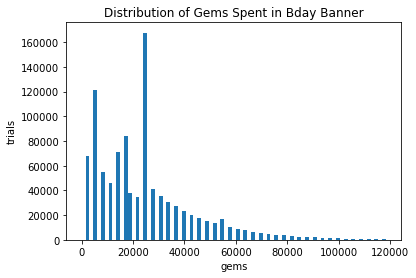

In [166]:
fig,ax = plt.subplots(1,1)
ax.hist(bday_histo, cost_buckets)
ax.set_title("Distribution of Gems Spent in Bday Banner")
ax.set_xlabel('gems')
ax.set_ylabel('trials')
plt.show()

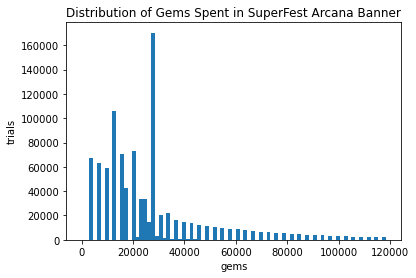

In [125]:
fig,ax = plt.subplots(1,1)
ax.hist(arcana_histo, cost_buckets)
ax.set_title("Distribution of Gems Spent in SuperFest Arcana Banner")
ax.set_xlabel('gems')
ax.set_ylabel('trials')
plt.show()

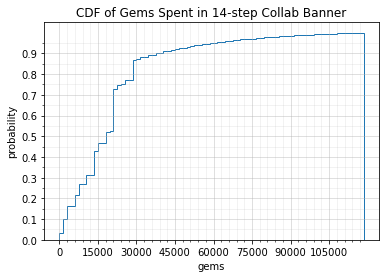

In [129]:
import numpy as np
fig,ax = plt.subplots(1,1)
"""
ax.hist(collab_histo, cost_buckets)
ax.set_title("Distribution of Gems Spent in 14-step Collab Banner")
ax.set_xlabel('gems')
ax.set_ylabel('trials')
plt.show()
"""

ax.hist(collab_histo, cost_buckets, density=True, histtype='step', cumulative=True)
# Major ticks every 20, minor ticks every 5
y_major_ticks = np.arange(0, 1, 0.1)
y_minor_ticks = np.arange(0, 1, 0.05)

x_major_ticks = np.arange(0, 120000, 15000)
x_minor_ticks = np.arange(0, 120000, 3000)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.set_title("CDF of Gems Spent in 14-step Collab Banner")
ax.set_xlabel('gems')
ax.set_ylabel('probability')
plt.show()

In [72]:
# RUN THIS CELL FOR DETERMINING CHANCE OF GETTING IN SPOTLIGHT

success = 0

for i in range(TRIALS):
    reset_spotlight_trial()
    if DEBUG_STATEMENTS:
        print("NEW TRIAL STARTED. FRESH BOX1 CONTENTS:")
        print(SET1)
        print()
    
    for j in range(NUM_OF_STEPS):
        if simulateOneSpotlight() == True:
            success += 1
            break

Chance_at_getting = success / TRIALS * 100
print()
print(f"AFTER RUNNING {TRIALS} TRIALS WITH {NUM_OF_STEPS} STEPS EACH,")
print(f"The simulated probability of getting Lover is {Chance_at_getting}%")

NEW TRIAL STARTED. FRESH BOX1 CONTENTS:
['stage girl', 'excellent', 'excellent', 'garbage', 'garbage', 'garbage', 'garbage', 'garbage', 'garbage']

step: 1, Received: garbage
WHAT'S LEFT IN BOX: ['stage girl', 'excellent', 'excellent', 'garbage', 'garbage', 'garbage', 'garbage', 'garbage']

step: 2, Received: garbage
WHAT'S LEFT IN BOX: ['stage girl', 'excellent', 'excellent', 'garbage', 'garbage', 'garbage', 'garbage']

step: 3, Received: garbage
WHAT'S LEFT IN BOX: ['stage girl', 'excellent', 'excellent', 'garbage', 'garbage', 'garbage']

step: 4, Received: ordinary excellent prize
WHAT'S LEFT IN BOX: ['stage girl', 'excellent', 'garbage', 'garbage', 'garbage']

step: 5, Received: garbage
WHAT'S LEFT IN BOX: ['stage girl', 'excellent', 'garbage', 'garbage']

step: 6, Received: garbage
WHAT'S LEFT IN BOX: ['stage girl', 'excellent', 'garbage']

step: 7, Received: garbage
WHAT'S LEFT IN BOX: ['stage girl', 'excellent']

step: 8, Received: ordinary excellent prize
WHAT'S LEFT IN BOX: ['